Epoch [1/100], Step [200/469], Gen Loss: 4.1042, Dis Loss: 0.0149
Epoch [1/100], Step [400/469], Gen Loss: 6.9325, Dis Loss: 0.0126
Epoch [2/100], Step [200/469], Gen Loss: 1.1411, Dis Loss: 0.3796
Epoch [2/100], Step [400/469], Gen Loss: 4.1790, Dis Loss: 0.0759
Epoch [3/100], Step [200/469], Gen Loss: 5.4365, Dis Loss: 0.1031
Epoch [3/100], Step [400/469], Gen Loss: 1.5140, Dis Loss: 0.9409
Epoch [4/100], Step [200/469], Gen Loss: 2.6694, Dis Loss: 0.1984
Epoch [4/100], Step [400/469], Gen Loss: 2.1340, Dis Loss: 0.3918
Epoch [5/100], Step [200/469], Gen Loss: 3.4455, Dis Loss: 0.1236
Epoch [5/100], Step [400/469], Gen Loss: 2.9834, Dis Loss: 0.1141
Epoch [6/100], Step [200/469], Gen Loss: 3.1001, Dis Loss: 0.0640
Epoch [6/100], Step [400/469], Gen Loss: 3.2570, Dis Loss: 0.0717
Epoch [7/100], Step [200/469], Gen Loss: 3.0735, Dis Loss: 0.3768
Epoch [7/100], Step [400/469], Gen Loss: 3.2917, Dis Loss: 0.0831
Epoch [8/100], Step [200/469], Gen Loss: 3.8201, Dis Loss: 0.0829
Epoch [8/1

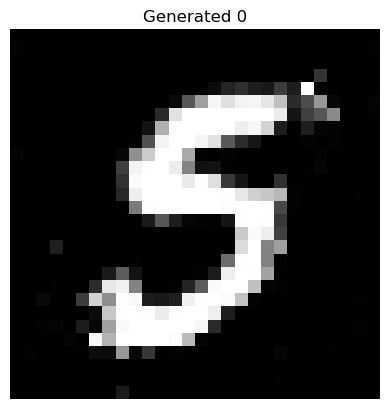

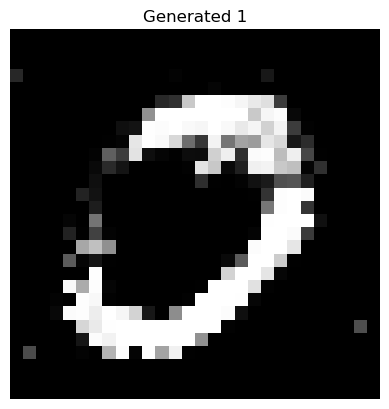

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.0002
batch_size = 128
epochs = 100

# 데이터셋 로딩
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 생성기 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# 판별기 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 손실 함수 및 최적화기 정의
criterion = nn.BCELoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
dis_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# 학습 루프
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        if real_images.size(0) != batch_size:  # 배치 크기가 일치하지 않는 경우 건너뜁니다
            continue
        real_images = real_images.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # 생성기 학습
        gen_optimizer.zero_grad()
        z = torch.randn(batch_size, 100).to(device)
        fake_images = generator(z)
        gen_loss = criterion(discriminator(fake_images), real_labels)
        gen_loss.backward()
        gen_optimizer.step()

        # 판별기 학습
        dis_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_images), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        dis_loss = (real_loss + fake_loss) / 2
        dis_loss.backward()
        dis_optimizer.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Gen Loss: {gen_loss.item():.4f}, Dis Loss: {dis_loss.item():.4f}')

# 원하는 숫자 생성
def generate_digit(digit):
    z = torch.randn(1, 100).to(device)
    with torch.no_grad():
        fake_image = generator(z)
    fake_image = fake_image.view(28, 28).cpu().numpy()
    plt.imshow(fake_image, cmap='gray')
    plt.title(f'Generated {digit}')
    plt.axis('off')
    plt.show()

# 생성기 테스트
generate_digit(0)  # 숫자 0 생성
generate_digit(1)  # 숫자 1 생성

